# Automatically build the training set of annotated images

We want to automatically generate an annotated set of images with the TTA. The division events are spotted on the RFP images using a neural network. When an event is spotted, we take the first frame of happening, this is our starting frame $f$ at position $(x,y)$. We take a squared patch of the image, centered on $(x,y)$ of size $(2d, 2d)$ on a stack of frames, from $f - 8$ (arbitrary) to $f$. 

In [1]:
import cv2
import imageio
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import scipy
from skimage.measure import find_contours # to get contours from masks
from skimage.filters import threshold_otsu

# btrack module and configuration file
import btrack
from btrack.dataio import localizations_to_objects
from btrack.constants import BayesianUpdates
from btrack.render import plot_tracks

import imagecodecs
import napari

C:\Users\Lab513\AppData\Roaming\Python\Python38\site-packages\napari\_qt\__init__.py:38: UserWarning: napari was tested with QT library `>=5.12.3`.
The version installed is 5.9.7. Please report any issues with this specific QT version at https://github.com/Napari/napari/issues.
  warn(message=warn_message)


# 1. Get the contours

<ipython-input-2-384a37b2b573>:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  contours = np.array(contours)
<ipython-input-2-384a37b2b573>:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  contours32.append(np.array(cont))
<ipython-input-2-384a37b2b573>:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  contours = np.array(contours32

(120,)


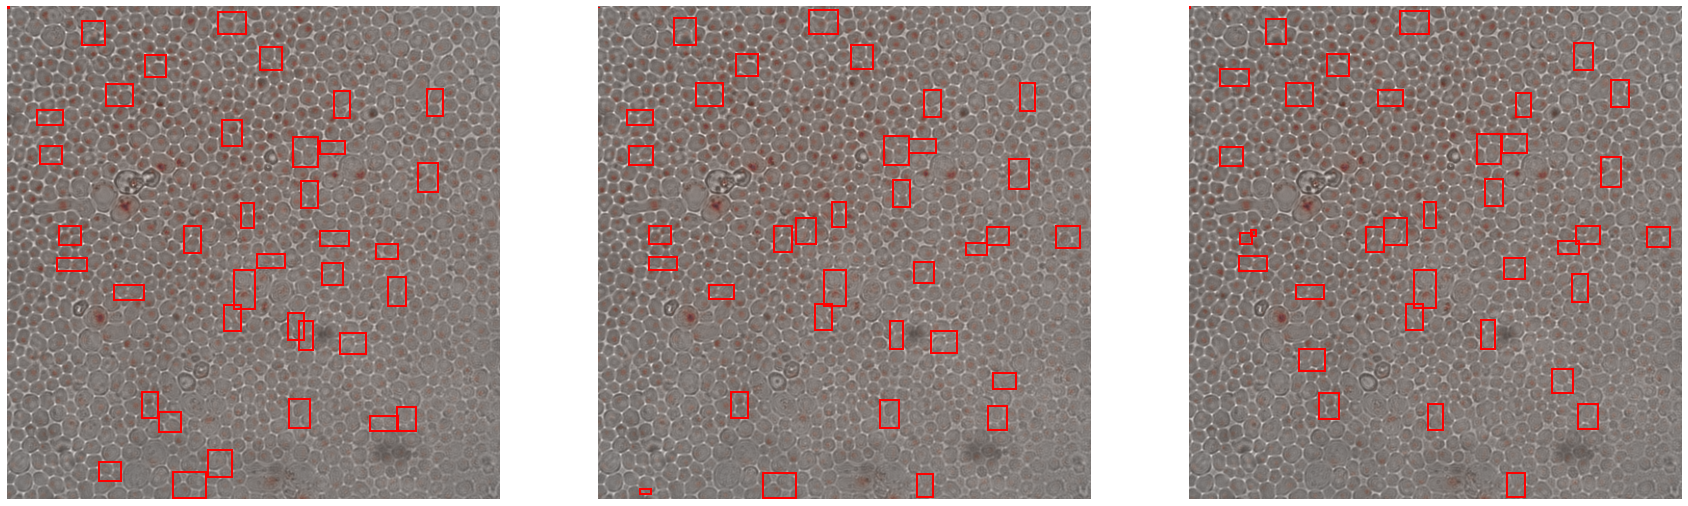

In [2]:
# load images and divided nuclei
os.chdir("D:/Hugo/Anaphase/DL/H449")  # root dir containg Predictions and Images Path

bf_imgs = imageio.volread("BF_1-120.tif") # bf images
rfp_ims = imageio.volread("RFP_1-120.tif")  # rfp images
division_masks = imageio.volread("BS300_H449_pos2_1-120_clean.tif") # masks

thresh = threshold_otsu(division_masks)
binary_masks = division_masks > thresh

# get the contours with skimage : 1 array per frame, each array contains arrays = contours
contours = []
for im in binary_masks:
    contour = find_contours(im, level=(np.max(im) + np.min(im)) / 2) # list of (nx2) arrays, each array is a contour
    contours.append(contour)
contours = np.array(contours)

# cast to 32-float for opencv ...
contours32 = []
for c in contours:
    cont = []
    for pos in c:
        cont.append(pos.astype(np.float32))
    contours32.append(np.array(cont))
contours = np.array(contours32)

print(contours.shape)

plot_contours = True
if plot_contours:
    import matplotlib.colors as mcolors
    by_hsv = [(tuple(mcolors.rgb_to_hsv(mcolors.to_rgb(color))),
                             name) for name, color in mcolors.TABLEAU_COLORS.items()]
    names = [name for hsv, name in by_hsv]

    init_idx, nb_imgs = 100, 3
    fig, axes = plt.subplots(1, nb_imgs, figsize=(10 * nb_imgs, 10))

    for i, (contour_im, im, rfp_im, ax) in enumerate(zip(contours[init_idx:init_idx+nb_imgs], bf_imgs[init_idx:init_idx+nb_imgs], rfp_ims[init_idx:init_idx+nb_imgs], axes)):
        ax.imshow(im, cmap="gray", origin="upper")
        ax.imshow(rfp_im, cmap="Reds", origin="upper", alpha=0.3)
        for i, contour in enumerate(contour_im):
            x, y, w, h = cv2.boundingRect(contour)
            p = patches.Rectangle((y, x), h, w, fill=False, linewidth=2, angle=0, color="r")
            ax.add_artist(p)
        ax.axis("off")

# 2. Perform tracking of the dividing nuclei and retrieve their position

3389 detected cells on 120 frames.


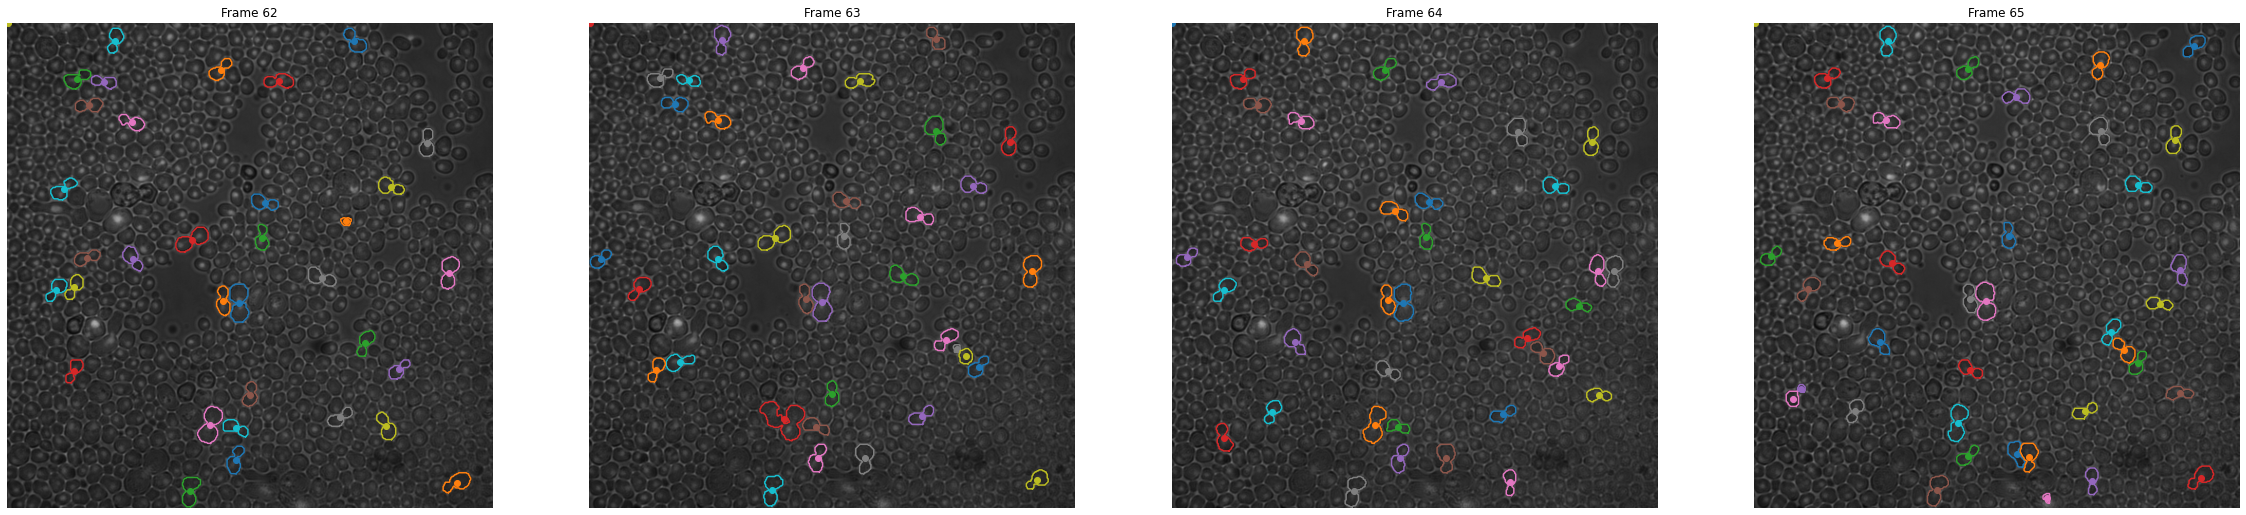

In [3]:
time_step = 1  # one image per 6 minutes

# retrieve all barycenters and shape a datastructure for btrack
positions_at_frames = []
for i, frame in enumerate(contours):
    for cell in frame:
        positions_at_frames.append({"t": i, "time": i * time_step, "x": np.sum(cell[:, 1]) / cell.shape[0], "y": np.sum(cell[:, 0]) / cell.shape[0], "contours": cell})
positions_per_frame = pd.DataFrame(positions_at_frames)

# check the shape
nb_frames = positions_per_frame["t"].unique().shape[0]
print(f"{positions_per_frame.shape[0]} detected cells on {nb_frames} frames.")

# Display the image and plot the barycenters to check if they're correct
plot_contours = True
if plot_contours:
    import matplotlib.colors as mcolors
    by_hsv = [(tuple(mcolors.rgb_to_hsv(mcolors.to_rgb(color))),
                             name) for name, color in mcolors.TABLEAU_COLORS.items()]
    names = [name for hsv, name in by_hsv]

    init_idx, nb_imgs = 62, 4
    fig, axes = plt.subplots(1, nb_imgs, figsize=(10 * nb_imgs, 10))

    for i, (im, rfp_im, ax) in enumerate(zip(bf_imgs[init_idx:init_idx+nb_imgs], rfp_ims[init_idx:init_idx+nb_imgs], axes)):
        contour_im = positions_per_frame[positions_per_frame["t"] == init_idx + i]
        ax.imshow(im, cmap="gray", origin="upper")
        ax.imshow(rfp_im, cmap="gray", origin="upper", alpha=0.5)
        for idx, cell in contour_im.iterrows():
            x, y = cell["x"], cell["y"]
            ax.scatter(x, y, c=names[idx% len(names)])
            ax.plot(cell["contours"][:, 1], cell["contours"][:, 0], c=names[idx % len(names)])
        ax.axis("off")
        ax.set_title(f"Frame {init_idx + i}")

### Run position-based tracking with btrack

In [4]:
import time

# os.chdir("D:/Hugo/Python_Scripts/Notebooks")
MODE = BayesianUpdates.EXACT # APPROXIMATE or EXACT
objects = localizations_to_objects(positions_per_frame)
objects[0]

t0 = time.time()

# initialise a tracker session using a context manager
with btrack.BayesianTracker() as tracker:

  # configure the tracker using a config file (example config file used here)
    tracker.configure_from_file("config_file.json")

  # set the update method and maximum search radius (both optional)
    tracker.update_method = MODE
    tracker.max_search_radius = 10

  # append the objects to be tracked
    tracker.append(objects)

  # set the volume (Z axis volume is set very large for 2D data)
    tracker.volume=((0,600),(0,600),(-1e5,1e5))

  # track them (in interactive mode)
    tracker.track_interactive(step_size=100)

  # generate hypotheses and run the global optimiser
#   tracker.optimize()

  # get the tracks as a python list
    tracks = tracker.tracks
    box = tracker.volume
    
tf = time.time()
print(f"Tracking duration : {round(tf - t0, 2)} seconds.")

[INFO][2021/06/10 03:03:01 PM] Objects are of type: <class 'pandas.core.frame.DataFrame'>
[INFO][2021/06/10 03:03:01 PM] Loaded btrack: C:\ProgramData\Anaconda3\lib\site-packages\btrack\libs\libtracker.DLL
[INFO][2021/06/10 03:03:01 PM] btrack (v0.4.0) library imported
[INFO][2021/06/10 03:03:01 PM] Setting max XYZ search radius to: 100
[INFO][2021/06/10 03:03:01 PM] Starting BayesianTracker session
[INFO][2021/06/10 03:03:01 PM] Loading configuration file: config_file.json
[INFO][2021/06/10 03:03:01 PM] Loading motion model: b'cell_motion'
[INFO][2021/06/10 03:03:01 PM] Setting Bayesian update method to: BayesianUpdates.EXACT
[INFO][2021/06/10 03:03:01 PM] Setting max XYZ search radius to: 10
[INFO][2021/06/10 03:03:01 PM] Objects are of type: <class 'list'>
[INFO][2021/06/10 03:03:01 PM] Set volume to ((0, 600), (0, 600), (-100000.0, 100000.0))
[INFO][2021/06/10 03:03:01 PM] Starting tracking... 
[INFO][2021/06/10 03:03:01 PM] Tracking objects in frames 0 to 99 (of 120)...
[INFO][202

Tracking duration : 0.26 seconds.


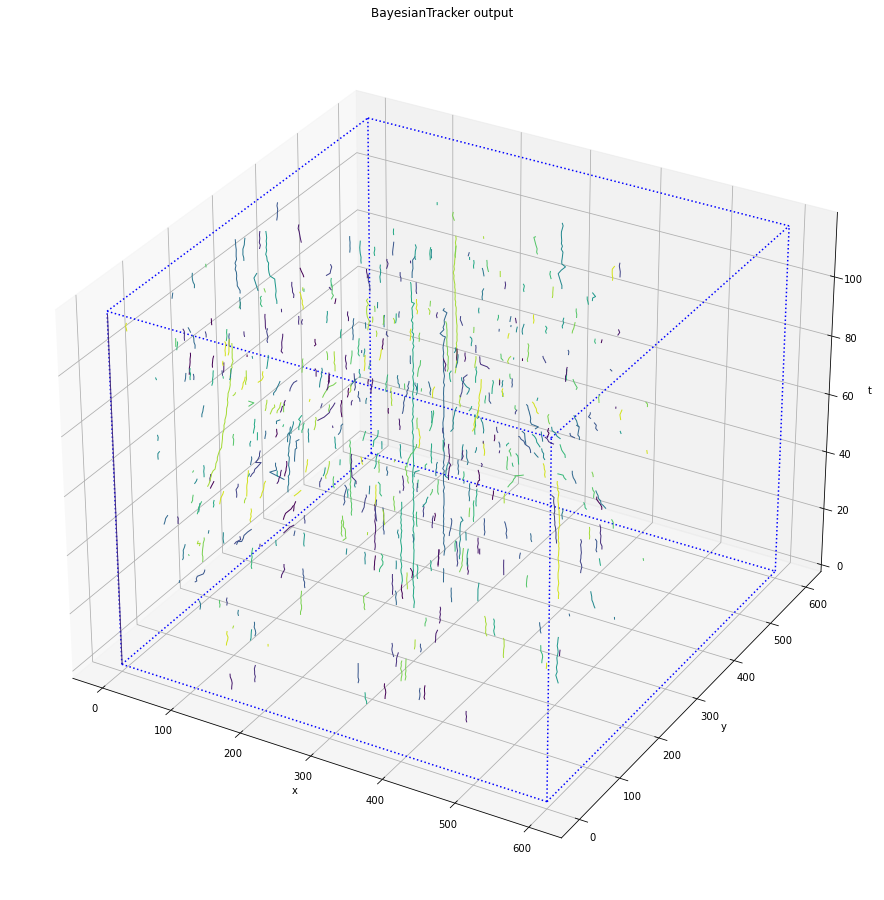

In [5]:
# plot the tracks in 3D
plot_tracks(tracks, order='xyt', box=box)

In [11]:
from napari_animation import AnimationWidget

# Convert from the btrack format (data structure == OrderedDict) into a format that is accepted by Napari (i.e. numpy array)
tracks_to_napari = []
for track in tracks:
    for i, time in enumerate(track.t):
        tracks_to_napari.append({"ID": track.ID, "Time": time, "X": track.y[i], "Y": track.x[i]})
tracks_to_napari = pd.DataFrame(tracks_to_napari)

print(tracks_to_napari.shape)

view_tracks = True
if view_tracks:  
    viewer = napari.Viewer()
    viewer.add_image(bf_imgs)
    viewer.add_image(rfp_ims, opacity=0.25, blending="additive", colormap="reds")
    viewer.add_image(division_masks, opacity=0.5, colormap="blue", blending="additive")
    viewer.add_tracks(tracks_to_napari)

#     animation_widget = AnimationWidget(viewer)
#     viewer.window.add_dock_widget(animation_widget, area='right')
    
    napari.run()

(3242, 4)


In [12]:
# join the predictions to the tracks
k, count = 0, 0

print(positions_per_frame.shape)

positions_per_frame["ID"] = pd.Series.empty

def get_closest_point(x, y, t, df, max_dist=10):
    """
    For a given point (x, y, t), searches for the closest point (x+dx, y+dx, t+lag)
    within an area of radius lower than max_dist, for increasing values of lag. Helps
    to retrieve the contours of a cell when it is in the track but the contours are lost
    at the segmentation step.
    """
    
    euclidian_dist = np.vectorize(lambda x1, x2, y1, y2: np.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2))
    
    lag = 1
    subs = df[df["time"] == t + lag]
    if subs.empty:
        print("empty")
        return None, None, None

    while not subs.empty and np.min(euclidian_dist(x, subs["y"], y, subs["x"])) > max_dist and lag <= 10:  # x and y are inverted between position_per_frame and tracks
        lag += 1
        subs = df[df["time"] == t + lag]
        
    closest_index = np.argmin(euclidian_dist(x, subs["y"], y, subs["x"]))
    
    return t + lag, subs.iloc[closest_index]["x"], subs.iloc[closest_index]["y"]
    
# iterate on the tracks and retrieve the track ID corresponding to each cell at each instant
# some cells are missing in the tracks (i.e. the track was made even though no cell was detected)
# for those cells we retrieve the closest cell at the following frames
for k, idx in enumerate(tracks_to_napari["ID"].unique()):
    track = tracks_to_napari[tracks_to_napari["ID"] == idx]
    
    if k % 100 == 0:
        print(f"Line {k}")
        print(f"Number of retrieved cells: {count}")
        
    for t, x, y in zip(track["Time"], track["X"], track["Y"]):
        if not positions_per_frame[(positions_per_frame["x"] == y) & (positions_per_frame["y"] == x) & (positions_per_frame["time"] == t)].empty:
            index = positions_per_frame[(positions_per_frame["x"] == y) & (positions_per_frame["y"] == x) & (positions_per_frame["time"] == t)]["ID"].index
            positions_per_frame.at[index, "ID"] = track[(track["Time"] == t) & (track["X"] == x) & (track["Y"] == y)]["ID"].values[0]
            count += 1
        else:
            next_time, next_x, next_y = get_closest_point(x, y, t, positions_per_frame, max_dist=10)
                        
            if t is not None and x is not None and y is not None:
                positions_per_frame = positions_per_frame.append({"ID": track[(track["Time"] == t) & (track["X"] == x) & (track["Y"] == y)]["ID"].values[0], 
                                            "x": y, "y": x, "time": t, "t": t // time_step,
                                            "contours": positions_per_frame[(positions_per_frame["time"] == next_time) & (positions_per_frame["x"] == next_x) & (positions_per_frame["y"] == next_y)]["contours"].values[0]}, 
                                            ignore_index=True)
                count += 1
            else: 
                continue
            
    k += 1
    
print(k, count)

print(f"Number of retrieved cells : {count}")

positions_per_frame.head()

(3389, 5)
Line 0
Number of retrieved cells: 0
Line 100
Number of retrieved cells: 933
Line 200
Number of retrieved cells: 1495
Line 300
Number of retrieved cells: 2034
Line 400
Number of retrieved cells: 2463
Line 500
Number of retrieved cells: 2920
595 3242
Number of retrieved cells : 3242


,t,time,x,y,contours,ID
0,0,0,0.250000,0.250000,"[[0.0, 0.5], [0.5, 0.0]]",2
1,0,0,147.952381,19.404762,"[[28.5, 140.0], [28.5, 139.0], [28.5, 138.0], ...",1
2,0,0,321.404040,95.005051,"[[108.5, 319.0], [108.5, 318.0], [108.5, 317.0...",15
3,0,0,88.513761,100.995413,"[[115.5, 89.0], [115.5, 88.0], [115.5, 87.0], ...",14
4,0,0,74.133333,138.461905,"[[150.5, 80.0], [150.5, 79.0], [150.5, 78.0], ...",13


# 3. Generate the images

For now the images are generated using the following protocol:
- The anaphase events are detected using the BS300 model
- They are tracked using btrack (with low search radius)
- For each anaphase, we now know when and where it occurs from beginning until its end
- We can retrieve using the position $(x, y, t)$ the corresponding patch $(x - dx, x + dx, y - dy, y + dy, t - dt, t + dt)$
- For now $dx, dy, dt$ are fixed to get 32x32 images and a constant time window before and after the anaphase

Taking each time step between $t - dt$ and $t + dt$ could lead to an artificially large amount of images, with a lot of them being quasi-identical. The consequences are that the training step will be significantly long. We choose to randomly subsample e.g. 10 images between $t - dt$ and $t + dt$.

Implement the three modes:
- constant $dx, dy$
- bounding box + padding -> 64x64
- contours + padding -> 64x64

In [32]:
from shutil import rmtree

# test with a single-event
movie = "H449"
time_step, target_width, target_height, dt_ante, dt_post = 1, 64, 64, 20, 5
nb_images_per_event = 20
save_path = "D:\Hugo\Anaphase\DL\H449\\images"

if os.path.isdir(save_path):
    rmtree(save_path)
os.mkdir(save_path)

positions_per_frame.rename({"x": "Y", "y": "X", "time": "Time", "t": "Frame", "contours": "Contours"}, inplace=True, axis="columns")
tracks_final = positions_per_frame.set_index("ID")
# tracks_final["Time"] = tracks_final["Frame"] * time_step
metadata = []


for idx in tracks_final.index.unique():
    event = tracks_final.loc[idx]
    
    if type(event) == pd.DataFrame and event.shape[0] > 1 and event.shape[0] < 6:  # filter outliers (more than one frame, less than six frames...)
        
        anaphase_time = int(event.iloc[0]["Time"])
        init_time, final_time = np.max((0, anaphase_time - dt_ante)), np.min((bf_imgs.shape[0], anaphase_time + dt_post + 1))  # to avoid out of range on the image stack
        nb_ims_to_take = np.min((nb_images_per_event, int((final_time - init_time) / time_step)))
#         times = np.random.choice([k for k in range(init_time, final_time, time_step)], size=nb_ims_to_take, replace=False)  # randomly sample e.g. 10 images for each event (< all images)
        times = range(init_time, final_time, time_step)
        for t in sorted(times):
            if t in event["Time"].values: # during tracking the anapahse, choose the right position
                x, y, dx, dy = cv2.boundingRect(event[event["Time"] == t]["Contours"].values[0])
            elif t < event["Time"].min():  # before the first tracking frame, choose the first recorder position
                x, y, dx, dy = cv2.boundingRect(event.iloc[0]["Contours"])
            else:  # after the last tracking frame, choose the last recorded position
                x, y, dx, dy = cv2.boundingRect(event.iloc[-1]["Contours"])
                

            # compute the TTA
            tta = (anaphase_time - t) * time_step

            # save the image
            title = f"{movie}_{idx}_t{t}_x{x}_y{y}_tta{tta}"
#             left, right, bottom, top = np.max((0, x-dx)), np.min((bf_imgs.shape[2], x+dx)), np.max((0, y-dy)), np.min((bf_imgs.shape[1], y+dy)) 
            left, right, bottom, top = np.max((0, x - 3)), np.min((bf_imgs.shape[2], x + dx + 3)), np.max((0, y - 3)), np.min((bf_imgs.shape[1], y + dy + 5))
            bf = bf_imgs[t, left:right, bottom:top]
        
            if bf.shape[0] < 15 or bf.shape[1] < 12: # fitler outliers
                continue
            
             # pad images in case of missing part
            if bf.shape[0] > target_width:
                bf = bf[:target_width, :]
            if bf.shape[1] > target_height:
                bf = bf[:, :target_height]
                
            if bf.shape[0] < target_width:
                to_add = target_width - bf.shape[0]
                if to_add % 2  == 0:
                    bf = np.concatenate((np.zeros((to_add // 2, bf.shape[1]), dtype=bf.dtype), bf), axis=0)
                    bf = np.concatenate((bf, np.zeros((to_add // 2, bf.shape[1]), dtype=bf.dtype)), axis=0)
                else:
                    bf = np.concatenate((np.zeros((to_add // 2 + 1, bf.shape[1]), dtype=bf.dtype), bf), axis=0)
                    bf = np.concatenate((bf, np.zeros((to_add // 2, bf.shape[1]), dtype=bf.dtype)), axis=0)
            if bf.shape[1] < target_height:
                to_add = target_height - bf.shape[1]
                if to_add % 2  == 0:
                    bf = np.concatenate((np.zeros((bf.shape[0], to_add // 2), dtype=bf.dtype), bf), axis=1)
                    bf = np.concatenate((bf, np.zeros((bf.shape[0], to_add // 2), dtype=bf.dtype)), axis=1)
                else:
                    bf = np.concatenate((np.zeros((bf.shape[0], to_add // 2 + 1), dtype=bf.dtype), bf), axis=1)
                    bf = np.concatenate((bf, np.zeros((bf.shape[0], to_add // 2), dtype=bf.dtype)), axis=1)
            if bf.shape != (target_width, target_height):
                print(f"Target shape: {(target_width, target_height)}, Real shape: {bf.shape}")
                
            
            # save metadata
            metadata.append({"ID": idx,
                             "Time": t,
                             "X": x,
                             "Y": y,
                             "TTA": tta,
                             "Time_Step": time_step,
                             "dt_ante": dt_ante,
                             "dt_poste": dt_post,
                             "width": dx,
                             "height": dy,
                             "File_name": title,
                             "Movie": movie})
                
            imageio.imwrite(f"{save_path}/{title}.tif", bf)


metadata = pd.DataFrame(metadata)
metadata.to_csv("Metadata_annotated_images_TTA_pred_DL.csv", sep=",")

In [37]:
from shutil import copyfile

# move the images from the current to the main dataset (containing all the other ones)
repo = "D:\Hugo\Anaphase\DL\H449.2"
repo_images = f"{repo}/images"
repo_metadata = pd.read_csv(f"{repo}/Metadata_annotated_images_TTA_pred_DL.csv", sep=",")
main_repo = "D:\Hugo\Anaphase\DL"
main_repo_images =  f"{main_repo}/images"

if not os.path.isdir(main_repo_images):
    os.mkdir(main_repo_images)
    
repo_content, main_repo_content = os.listdir(repo_images), os.listdir(main_repo_images)

for im in repo_content:
    if not im in main_repo_content:
        copyfile(f"{repo_images}/{im}", f"{main_repo_images}/{im}")
        
if not "Metadata_annotated_images_TTA_pred_DL.csv" in os.listdir(main_repo):
    main_metadata = repo_metadata
    print(f"Created metadata file with {repo_metadata.shape} images.")
else:
    main_metadata = pd.read_csv(f"{main_repo}/Metadata_annotated_images_TTA_pred_DL.csv", sep=",")
    print(f"Previous number of images : {main_metadata.shape}")
    main_metadata = pd.concat([main_metadata, repo_metadata], axis=0)
    print(f"Current number of images : {main_metadata.shape}")

main_metadata.to_csv(f"{main_repo}/Metadata_annotated_images_TTA_pred_DL.csv", sep=",")

Previous number of images : (12806, 16)
Current number of images : (12806, 17)


# Train-test split

In [38]:
from shutil import copyfile

root = "D:\Hugo\Anaphase\DL"
dir_name = "D:\Hugo\Anaphase\DL\Images"
train_set_path, val_set_path, test_set_path = "D:\Hugo\Anaphase\DL\Train_Set", "D:\Hugo\Anaphase\DL\Validation_Set", "D:\Hugo\Anaphase\DL\Test_Set"
train_set_size, validation_set_size = 0.90, 0.1  # validation set : validation set size * train_set_size
split_by_trajectory = False  # False : split by individual

if os.path.isdir(train_set_path):
    rmtree(train_set_path)
os.mkdir(train_set_path)

if os.path.isdir(val_set_path):
    rmtree(val_set_path)
os.mkdir(val_set_path)
    
if os.path.isdir(test_set_path):
    rmtree(test_set_path)
os.mkdir(test_set_path)

if split_by_trajectory:
    metadata = pd.read_csv(f"{root}/Metadata_annotated_images_TTA_pred_DL.csv", sep=",", index_col="ID")
    metadata["train_or_test"] = pd.Series.empty
    
    movie_and_index = metadata[["Movie", "ID"]].values.unique()
    train_set = np.random.choice(movie_and_index, replace=False, size=int(train_set_size * movie_and_index.shape[0]))
    validation_set = train_set[int((1 - validation_set_size) * train_set.size):] # validation set = last images of train set
    train_set = train_set[:int((1 - validation_set_size) * train_set.size)]
    print(train_set)
    
    test_set = []
    for movie, index in metadata[["Movie", "ID"]]:
        if not [movie, index] in train_set and not [movie, index] in validation_set:
            test_set.append([movie, index])
    test_set = np.array(test_set).reshape(-1, 2)
    print(test_set)
    
    for movie, index in train_set:
        point_idx = metadata[(metadata["Movie"] == movie) & (metadata["ID"] == index)].index
        metadata.loc[point_idx, "train_or_test"] = "train"
        filename = metadata.loc[point_idx, "File_name"]
        copyfile(f"{dir_name}/{file_name}.tif", f"{train_set_path}/{file_name}.tif")
        
    for movie, index in validation:
        point_idx = metadata[(metadata["Movie"] == movie) & (metadata["ID"] == index)].index
        metadata.loc[point_idx, "train_or_test"] = "validation"
        filename = metadata.loc[point_idx, "File_name"]
        copyfile(f"{dir_name}/{file_name}.tif", f"{val_set_path}/{file_name}.tif")
        
    for movie, index in test_set:
        point_idx = metadata[(metadata["Movie"] == movie) & (metadata["ID"] == index)].index
        metadata.loc[point_idx, "train_or_test"] = "test"
        filename = metadata.loc[point_idx, "File_name"]
        copyfile(f"{dir_name}/{file_name}.tif", f"{test_set_path}/{file_name}.tif")
else:
    metadata = pd.read_csv(f"{root}/Metadata_annotated_images_TTA_pred_DL.csv", sep=",")
    metadata["train_or_test"] = pd.Series.empty

    file_names = metadata["File_name"].values
    train_set = np.random.choice(file_names, replace=False, size=int(train_set_size * file_names.shape[0]))
    validation_set = train_set[int((1 - validation_set_size) * train_set.size):] # validation set = last images of train set
    train_set = train_set[:int((1 - validation_set_size) * train_set.size)]

    test_set = []
    for f in file_names:
        if not f in train_set and not f in validation_set:
            test_set.append(f)
    test_set = np.array(test_set)

    for file_name in train_set:
        idx = metadata[metadata["File_name"] == file_name].index
        metadata.loc[idx, "train_or_test"] = "train"
        copyfile(f"{dir_name}/{file_name}.tif", f"{train_set_path}/{file_name}.tif")
        
    for file_name in validation_set:
        idx = metadata[metadata["File_name"] == file_name].index
        metadata.loc[idx, "train_or_test"] = "validation"
        copyfile(f"{dir_name}/{file_name}.tif", f"{val_set_path}/{file_name}.tif")

    for file_name in test_set:
        idx = metadata[metadata["File_name"] == file_name].index
        metadata.loc[idx, "train_or_test"] = "test"
        copyfile(f"{dir_name}/{file_name}.tif", f"{test_set_path}/{file_name}.tif")

metadata.to_csv(f"{root}/Metadata_annotated_images_TTA_pred_DL.csv", sep=",")
    
train_size, val_size, test_size = len(os.listdir(train_set_path)), len(os.listdir(val_set_path)), len(os.listdir(test_set_path))
print(f"Train-test split done.\nTrain set images : {train_size}.\nValidation set images: {val_size}\nTest set images: {test_size}.")

Train-test split done.
Train set images : 10372.
Validation set images: 1153
Test set images: 1281.
